## **Notebook for all the little code snippets for the code cleaning of stareg**

TODOs:
- [x] B-spline
- [x] TP-Bspline
- [x] Penalty and smoothness matrices
- [ ] check_constraint
- [ ] star_model

I'll try to use as little external libraries as possible.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.sparse import diags
from scipy.linalg import block_diag
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from functools import singledispatch

In [2]:
class Bspline():
    
    def basisfunction(self, X, knots, j, l):
        """B-spline basis function definition according to Fahrmeir, Regression p.429.

        Parameters:
        -----------
        X :      array   - Input data of shape (n_samples, ) to evaluate the B-spline basis function 
                           of order l on.
        knots :  array   - Knot sequence defining the B-spline basis function.
        j :      int     - Index of the B-spline basis function to evaluate.
        l :      int     - Order of the B-spline basis function, e.g. l=3 -> cubic.

        Returns:
        --------
        b : array     - B-spline basis function evaluated at X. 

        """
        if l == 0:
            b = ((knots[j] <= X) & (X < knots[j+1])).astype(int)
            return b
        else:
            b0 = (X - knots[j-l]) / (knots[j] - knots[j-l])
            b1 = (knots[j+1] - X) / (knots[j+1] - knots[j+1-l])
            b = b0*self.basisfunction(X, knots, j-1, l-1) + b1*self.basisfunction(X, knots, j, l-1)
            return b


    def basismatrix(self, X, nr_splines=10, l=3, knot_type="e"):
        """Generate the B-spline basis matrix for nr_splines given the data X.

         Note: (nr_splines + l + 1) knots are needed for a B-spline basis of 
               order l with nr_splines, e.g. for l=3, nr_splines=10 -> len(knots) = 14. 

         Parameters:
         ----------
         X :          array  -  Input data of shape (n_samples, ) to compute the B-spline basis matrix for.
         nr_splines : int    -  Number of parameters (== number of B-spline basis functions).
         l :          int    -  Specifies the order of the B-spline basis functions.
         knot_type :  str    -  Decide between equidistant "e" and quantile based "q"
                                knot placement.

         Returns:
         --------
         B : matrix  - B-spline basis matrix of shape: ( length(x) x nr_splines ).
         k : array   - Knot sequence.

        """
        assert (len(X.shape) == 1), "Argument X is of wrong shape."
        B = np.zeros((len(X), nr_splines))
        xmin, xmax = X.min(), X.max()

        if knot_type is "e":
            knots_inner = np.linspace(xmin, xmax, nr_splines-l+1)
        elif knot_type is "q":
            p = np.linspace(0, 1, nr_splines-l+1);
            xs = np.sort(X, kind="quicksort")
            quantile_idx = np.array((len(X)-1)*p, dtype=np.int16)
            knots_inner = xs[quantile_idx]
        else:
            print(f"Knot Type {knot_type} not implemented!")
        
        dknots = np.diff(knots_inner).mean()
        knots_left = np.linspace(xmin-l*dknots, xmin-dknots, l)
        knots_right = np.linspace(xmax+dknots, xmax+l*dknots, l)
        knots = np.concatenate((knots_left, knots_inner, knots_right))

        for j in range(l,len(knots)-1):
            B[:,j-l] = self.basisfunction(X, knots, j, l);

        self.knot_type = knot_type
        self.l = l
        self.basis = B
        self.knots = knots
        return dict(basis=B, knots=knots)

    def fit(self, X, y, nr_splines=10, l=3, knot_type="e"):
        """Calculate the least squares parameters of the B-spline given the data X.

        Parameters:
        -----------
        X : array        - Input data of shape (n_samples, ).
        y : array        - Output data of shape (n_samples, ).
        nr_splines : int - Nr. of B-spline basis functions to use.
        l : int          - Order of the B-spline basis functions.
        knot_type : str  - Specifies the type of the knot sequence, either "e" or "q".

        Returns:
        --------
        coef_ : array  - Estimated coefficients of shape (nr_splines, ).
        B : matrix     - B-spline basis matrix.
        k : array      - Knot sequence 
        """
        if len(X.shape) == 1:
            B, k = self.basismatrix(X=X, nr_splines=nr_splines, l=l, knot_type=knot_type).values()
        elif X.shape[1] == 2:
            B, k1, k2 = self.tensorproduct_basismatrix(X=X, nr_splines=nr_splines, l=l, knot_type=knot_type).values()
            k = (k1, k2)
        else:
            print("Maximal dimension == 2!")
            return 
        solution = np.linalg.lstsq(a=B, b=y, rcond=None)      
        self.coef_ = solution[0]
        return dict(coef_=solution[0], basis=B, knots=k) 

    def predict(self, Xpred, coef, knots, l=3):
        """Calculate the B-spline value for X given the parameters in coef.

        Paramters:
        ----------
        X : array      - Data of shape (n_samples, ) to evaluate the B-spline on.
        coef  : array  - Parameters of the B-spline.
        knots : array  - Knot sequence of the B-spline.
        l : int        - Order of the B-spline.

        Returns:
        --------
        s : array   - B-spline values on X for the given parameters.

        """
        if len(Xpred.shape) == 1:
            print("Prediction for 1-D Data".center(30, "-"))
            B = np.zeros((len(Xpred), len(coef)))
            for j in range(l, len(knots)-1):
                B[:,j-l] = self.basisfunction(Xpred, knots, j, l)
                
        elif Xpred.shape[1] == 2:
            print("Prediction for 2-D Data".center(30, "-"))
            n_samples = len(Xpred[:,0])
            B1pred, B2pred = np.zeros((n_samples, len(knots[0])-1-l[0])), np.zeros((n_samples, len(knots[1])-1-l[1]))
            B = np.zeros((n_samples, len(coef)))

            for j in range(l[0], len(knots[0])-1):
                B1pred[:,j-l[0]] = self.basisfunction(Xpred[:,0], knots[0], j, l[0]) 
            for j in range(l[1], len(knots[1])-1):
                B2pred[:,j-l[1]] = self.basisfunction(Xpred[:,1], knots[1], j, l[1]) 
            for i in range(n_samples):
                B[i,:] = np.kron(B2pred[i,:], B1pred[i,:])    
        else:
            print("Maximal dimension == 2!")
            return 
        s = B @ coef
        return s    

    def tensorproduct_basismatrix(self, X, nr_splines=(7,7), l=(3,3), knot_type=("e", "e")):
        """Generate the 2-d tensor-product B-spline basis matrix for nr_splines[0] and
        nr_splines[1] for dimension 1 and 2.

        Parameters
        ----------
        X : array          - Input data of shape (n_samples, 2)
        nr_splines : list  - Contains the number of B-spline basis functions for each dimension.
        l : list           - Spline order for each dimensions.
        knot_type : list   - Knot types for each dimension.

        Returns:
        --------
        T  : matrix   - Tensor-product B-spline basis.
        k1 : array    - Knot sequence of dimension 1.
        k2 : array    - Knot sequence of dimension 2.
        """
        BS = Bspline()
        B1, k1 = BS.basismatrix(X[:,0], nr_splines[0], l[0], knot_type[0]).values()
        B2, k2 = BS.basismatrix(X[:,1], nr_splines[1], l[1], knot_type[1]).values()

        n_samples, n_dim = X.shape
        T = np.zeros((n_samples, nr_splines[0]*nr_splines[1]))
        for i in range(n_samples):
            T[i,:] = np.kron(B2[i,:], B1[i,:])

        self.basis = T
        self.knots = (k1, k2)
        return dict(basis=T, knots1=k2, knots2=k2)

    
    def fit_Pspline(self, X, y, nr_splines=10, l=3, knot_type="e", lam=1):
        """Implementation of the P-spline functionality given in Fahrmeir, Regression p.431ff.

        Solves the Ridge regression style problem of the form:
            coef = (X^t X + lam D_2^t D_2)^{-1} (X^t y)

        using X   ... B-spline basis matrix.
              D_2 ... Second-order finite difference matrix.
              lam ... Smoothness parameter. 

        Parameters:
        -----------
        X : array        - Input data of shape (n_samples, ).
        y : array        - Output data of shape (n_samples, ).
        nr_splines : int - Nr. of B-spline basis functions to use.
        l : int          - Order of the B-spline basis functions.
        knot_type : str  - Specifies the type of the knot sequence, either "e" or "q"
        lam : float      - Value of the smoothness parameter.

        Returns:
        --------
        coef_ : array  - Estimated coefficients of shape (nr_splines, ).
        B : matrix     - B-spline basis matrix.
        k : array      - Knot sequence 
        """
        if len(X.shape) == 1:
            B, k = self.basismatrix(X=X, nr_splines=nr_splines, l=l, knot_type=knot_type).values()
            D2 = mapping_matrix(n_param=nr_splines, constraint="smooth")
            coef_ = np.linalg.pinv(B.T@B + lam * (D2.T@D2)) @ (B.T @ y)
            D = D2
        elif X.shape[1] == 2:
            B, k1, k2 = self.tensorproduct_basismatrix(X=X, nr_splines=nr_splines, l=l, knot_type=knot_type).values()
            k = (k1, k2)
            Id2_D1, D2_Id1 = mapping_matrix_tp(n_param=nr_splines, constraints=("smooth", "smooth"))
            coef_ = np.linalg.pinv(B.T@B + lam[0] * (Id2_D1.T@Id2_D1) + lam[1] * (D2_Id1.T@D2_Id1)) @ (B.T@y)
            D = (Id2_D1, D2_Id1)
        else:
            print("Maximal dimension == 2!")
            return 

        self.Pspline_coef_ = coef_
        return dict(coef_=coef_, basis=B, knots=k, mapping_matrices=D)

    
    def calc_GCV(self, X, y, nr_splines=10, l=3, knot_type="e", nr_lam=10, plot_=1):
        """Calculate the generalized cross validation for the given data (x,y).

        Parameters: 
        -----------
        X : array        - Input data of shape (n_samples, n_dim).
        y : array        - Output data of shape (n_samples, ).
        nr_splines : int - Nr. of B-spline basis functions to use.
        l : int          - Order of the B-spline basis functions.
        knot_type : str  - Specifies the type of the knot sequence, either "e" or "q"
        nr_lam : float   - Number of lambdas to try out in the GCV.
        plot_    : bool  - Plot fit and smoothing paramter curve.

        Returns:
        --------
        coef_    : array   - Optimal coefficients for penalized least squares
                             fit using generalized cross validation.
        B        : matrix  - B-spline basis matrix.
        k        : array   - Knot sequence.
        best_lam : float   - Optimal smoothing parameter.
        """

        lambdas = np.logspace(-8,8,num=nr_lam)
        gcvs = np.zeros(nr_lam)

        for i, lam in enumerate(lambdas):
            if plot_: print(f"Test lam_{str(i+1)}= {lam}", end="\t")
            if len(X.shape) == 1:
                coef_pls, B, k, D = self.fit_Pspline(X=X, y=y,  nr_splines=nr_splines, l=l, knot_type=knot_type, lam=lam).values()
                trace_H = np.trace((B.T @ B) @ np.linalg.pinv(B.T@B + lam * (D.T@D)))
            elif X.shape[1] == 2:
                coef_pls, B, k, D = self.fit_Pspline(X=X, y=y,  nr_splines=nr_splines, l=l, knot_type=knot_type, lam=(lam, lam)).values()
                trace_H = np.trace((B.T @ B) @ np.linalg.pinv(B.T@B + lam * (D[0].T@D[0]) + lam * (D[1].T@D[1])))
            else:
                print("Only implemented for dim=1 and dim=2!")
                return
            ypred = B @  coef_pls
            gcvs[i] = sum(((y - ypred) / (1 - trace_H / len(y)) )**2) / len(y)

        best_gcv_idx = np.argmin(gcvs)
        best_lam = lambdas[best_gcv_idx]
        if plot_:
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=lambdas, y=gcvs, mode="lines", line=dict(width=1, color="blue"), name="Lambdas"))
            fig.add_trace(go.Scatter(x=[lambdas[best_gcv_idx]], y=[gcvs[best_gcv_idx]], mode="markers", 
                                     marker=dict(size=10, color="red", symbol=100), name="Optimal Value"))
            fig.update_layout(title="GCV-Search")        
            fig.update_xaxes(title_text = "lambdas", type="log")
            fig.update_yaxes(title_text = "GCV-Score", type="log")
            fig.show()

        return dict(best_lambda=best_lam)

    def fit_SC_Pspline(self, X, y, constraint="none", nr_splines=10, l=3, knot_type="e", lam_c=6000):
        """Implementation of the shape-constraint P-spline fit.

        Solve the Ridge regression style problem of the form:
            coef = (X^t X + lam D_2^t D_2 + lam_c D_c^t V D_c)^{-1} (X^t y)

        using X   ... B-spline basis matrix.
              D_2 ... Second-order finite difference matrix.
              lam ... Smoothness parameter. 
              D_c ... Mapping matrix of the constraint.
              V   ... Weighting matrix of the constraint.
              lam_c ... Constraint parameter.
        with lam give as optimal smoothing parameter by GCV.
        
        Parameters:
        -----------
        X : array        - Input data of shape (n_samples, ).
        y : array        - Output data of shape (n_samples, ).
        nr_splines : int - Nr. of B-spline basis functions to use.
        l : int          - Order of the B-spline basis functions.
        knot_type : str  - Specifies the type of the knot sequence, either "e" or "q"
        lam_c : float    - Value of the constraint parameter.
        constraint : str - Type of constraint.

        Returns:
        --------
        coef_ : array  - Estimated coefficients of shape (nr_splines, ).
        B : matrix     - B-spline basis matrix.
        k : array      - Knot sequence 
        lams : list    - Used smoothness parameter and and constraint parameter. 
        """

        lam = self.calc_GCV(X=X, y=y, nr_splines=nr_splines, l=l, knot_type=knot_type, nr_lam=100, plot_=0)["best_lambda"]
        coef_pls, B, k, D = self.fit_Pspline(X=X, y=y,  nr_splines=nr_splines, l=l, knot_type=knot_type, lam=lam).values()

        Ds = mm(nr_splines, constraint="smooth")
        Dc = mm(nr_splines, constraint=constraint)
        #Ds = mapping_matrix(n_param=nr_splines, constraint="smooth")
        #Dc = mapping_matrix(n_param=nr_splines, constraint=constraint)
        v = check_constraint(coef=coef_pls, constraint=constraint, y=y, B=B)
        vold = [0]*len(v)

        BtB = B.T @ B
        Bty = B.T @ y
        DstDs = Ds.T@Ds
        i = 1
        print(f"Pre-Iteration".center(30, "="))
        print(f"MSE = {mean_squared_error(y, B @coef_pls).round(7)}".center(30, "-"))
        df = pd.DataFrame(data=coef_pls)

        while not (v == vold):
            vold = v
            coef_pls = np.linalg.pinv(BtB + lam*DstDs + lam_c * Dc.T @ np.diag(v) @ Dc) @ (Bty)
            v = check_constraint(coef=coef_pls, constraint=constraint, y=y, B=B)
            print(f" Iteration {i} ".center(30, "="))
            print(f"MSE = {mean_squared_error(y, B @coef_pls).round(7)}".center(30, "-"))
            i += 1
            df = pd.concat([df, pd.DataFrame(data=coef_pls)], axis=1)

        return dict(coef_=coef_pls, basis=B, knots=k, lambdas=(lam, lam_c), df_coef=df)

    def fit_SC_TP_Pspline(self, X, y, constraints=("none", "none"), nr_splines=(10, 10), l=(3,3), knot_type=("e","e"), lam_c=(6000, 6000)):
        """Implementation of the constrained tensor-product P-spline fit.

        Solve the Ridge regression style problem of the form:
            coef = (X^t X + lam D_2^t D_2 + lam_c1 D_c1^t V1 D_c1 + lam_c2 D_C2^t V2 D_c2)^{-1} (X^t y)

        using X   ... B-spline basis matrix.
              D_2 ... Second-order finite difference matrix.
              lam ... Smoothness parameter. 
              D_c12 ... Mapping matrix of the constraint 1.
              D_c1  ... Mapping amtrix fo constraint 2.
              V1    ... Weighting matrix of the constraint 1.
              V2    ... Weighting matrix of the constraint 1.
              lam_c ... Constraint parameter.
        with lam give as optimal smoothing parameter by GCV.

        Parameters:
        -----------
        X : array        - Input data of shape (n_samples, ).
        y : array        - Output data of shape (n_samples, ).
        nr_splines : int - Nr. of B-spline basis functions to use.
        l : int          - Orders of the B-spline basis functions.
        knot_type : str  - Specifies the types of the knot sequence, either "e" or "q"
        lam_c : tuple    - Values of the constraint parameters.

        Returns:
        --------
        coef_ : array  - Estimated coefficients of shape (nr_splines, ).
        B : matrix     - B-spline basis matrix.
        k : array      - Knot sequence 
        lams : list    - Used smoothness parameter and and constraint parameter. 
        df : DataFrame - Contains the estimated coefficients for all interations.
        """

        lam = self.calc_GCV(X=X, y=y, nr_splines=nr_splines, l=l, knot_type=knot_type, nr_lam=50, plot_=1)["best_lambda"]
        coef_pls, B, k, D = self.fit_Pspline(X=X, y=y,  nr_splines=nr_splines, l=l, knot_type=knot_type, lam=(lam, lam)).values()

        Ds1, Ds2 = D
        Dc1, Dc2 = mapping_matrix_tp(n_param=nr_splines, constraints=constraints)
        v1 = check_constraint_tp(coef=coef_pls, nr_param=nr_splines, constraint=constraints[0], direction=1)
        v2 = check_constraint_tp(coef=coef_pls, nr_param=nr_splines, constraint=constraints[1], direction=0)

        v1old = [0]*len(v1)
        v2old = [0]*len(v2)

        BtB = B.T @ B
        Bty = B.T @ y
        DstDs_1 = Ds1.T@Ds1
        DstDs_2 = Ds2.T@Ds2

        i = 1
        df = pd.DataFrame(data=coef_pls)
        print(f"unconstrained MSE = {mean_squared_error(y, B @coef_pls).round(7)}".center(30, "-"))
        while not ((v1 == v1old) and (v2 == v2old)):
            v1old = v1
            v2old = v2
            Dc1tV1Dc1 = Dc1.T @ np.diag(v1) @ Dc1
            Dc2tV1Dc2 = Dc2.T @ np.diag(v2) @ Dc2
            coef_pls = np.linalg.pinv(BtB + lam*DstDs_1 + lam*DstDs_2 + lam_c[0] * Dc1tV1Dc1 +  lam_c[1] * Dc2tV1Dc2) @ (Bty)
            v1 = check_constraint_tp(coef=coef_pls, nr_param=nr_splines, constraint=constraints[0], direction=1)
            v2 = check_constraint_tp(coef=coef_pls, nr_param=nr_splines, constraint=constraints[1], direction=0)
            print(f" Iteration {i} ".center(30, "="))
            print(f"MSE = {mean_squared_error(y, B @coef_pls).round(7)}".center(30, "-"))
            i += 1
            df = pd.concat([df, pd.DataFrame(data=coef_pls)], axis=1)

        return dict(coef_=coef_pls, basis=B, knots=k, lambdas=(lam, (lam_c[0], lam_c[1])), df_coef=df)


In [3]:
def mapping_matrix(n_param=10, constraint="inc"):
    """Creates the mapping matrix for the constraint P-splines as in
    Fahrmeir, Regression p.436f.

    Paramters:
    ----------
    n_param : int     - Number of used B-spline basis functions.
    constraint : str  - Type of constraint.

    Returns:
    --------
    D : matrix     - Finite difference matrix of shape (n_param-order x n_param)
    """
    order = 1 if constraint in ["inc", "dec", "peak", "valley"] else 2
    assert (n_param > order), "n_param needs to be larger than order!"
    if order == 1:
        d1 = np.array([-1*np.ones(n_param),np.ones(n_param)])
        D = diags(d1,offsets=[0,1], shape=(n_param-order, n_param)).toarray()
    elif order == 2:
        d2 = np.array([np.ones(n_param),-2*np.ones(n_param),np.ones(n_param)])
        D = diags(d2,offsets=[0,1,2], shape=(n_param-order, n_param)).toarray()
    else:
        print(f"Finite difference matrix of order {order} is not implemented.")
        return
    return D

def mapping_matrix_tp(n_param=(10, 10), constraints=("inc", "inc")):
    """Creates the mapping matrix for the constraint tensor-product P-splines 
    as in Fahrmeir, Regression p.508 equation (8.27).

    Paramters:
    ----------
    n_param : tuple     - Numbers of used B-spline basis functions.
    constraint : tuple  - Types of constraint.

    Returns:
    --------
    Id2_D1 : matrix     - Mapping matrix of shape (n_param[0]*npara[1]-order1 x n_param[0]*n_param[1]).
    D2_Id1 : matrix     - Mapping matrix of shape (n_param[0]*npara[1]-order2 x n_param[0]*n_param[1]).

    Id2_D1 means Identity of dimension (n_param[1] x n_param[1]) \otimes Difference matrix of dimension (n_param[0]-order1 x n_param[0])
            the first subscript in D11 specifies the direction, the second speciefies the order of finite differences.
    """
    order1 = 1 if constraints[0] in ["inc", "dec", "peak", "valley"] else 2
    order2 = 1 if constraints[1] in ["inc", "dec", "peak", "valley"] else 2

    assert (n_param[0] > order1 and n_param[1] > order2), "n_param needs to be larger than order!"
    if order1 == 1:
        d1 = np.array([-1*np.ones(n_param[0]),np.ones(n_param[0])])
        D1 = diags(d1,offsets=[0,1], shape=(n_param[0]-order1, n_param[0])).toarray()
    elif order1 == 2:
        d2 = np.array([np.ones(n_param[0]),-2*np.ones(n_param[0]),np.ones(n_param[0])])
        D1 = diags(d2,offsets=[0,1,2], shape=(n_param[0]-order1, n_param[0])).toarray()
    else:
        print("Order too thigh for dimension 1!")
        return

    if order2 == 1:
        d1 = np.array([-1*np.ones(n_param[1]),np.ones(n_param[1])])
        D2 = diags(d1,offsets=[0,1], shape=(n_param[1]-order2, n_param[1])).toarray()
    elif order2 == 2:
        d2 = np.array([np.ones(n_param[1]),-2*np.ones(n_param[1]),np.ones(n_param[1])])
        D2 = diags(d2,offsets=[0,1,2], shape=(n_param[1]-order2, n_param[1])).toarray()
    else:
        print("Order too thigh for dimension 2!")
        return

    Id2_D1 = np.kron(np.eye(n_param[1]), D1)
    D2_Id1 = np.kron(D2, np.eye(n_param[1]))

    return (Id2_D1, D2_Id1)


@singledispatch
def mm(n_param, constraint="inc"):
    """Creates the mapping matrix for the constraint P-splines as in
    Fahrmeir, Regression p.436f, for the constraint.

    Paramters:
    ----------
    n_param : int     - Number of used B-spline basis functions.
    constraint : str  - Type of constraint.

    Returns:
    --------
    D : matrix     - Finite difference matrix of shape (n_param-order x n_param)
    """
    order = 1 if constraint in ["inc", "dec", "peak", "valley"] else 2
    assert (n_param > order), "n_param needs to be larger than order!"
    if order == 1:
        d1 = np.array([-1*np.ones(n_param),np.ones(n_param)])
        D = diags(d1,offsets=[0,1], shape=(n_param-order, n_param)).toarray()
    elif order == 2:
        d2 = np.array([np.ones(n_param),-2*np.ones(n_param),np.ones(n_param)])
        D = diags(d2,offsets=[0,1,2], shape=(n_param-order, n_param)).toarray()
    else:
        print(f"Finite difference matrix of order {order} is not implemented.")
        return
    return D

@mm.register
def _(n_param : tuple, constraint="inc", dim=0):
    """Creates the mapping matrix for the constraint tensor-product P-splines 
    as in Fahrmeir, Regression p.508 equation (8.27) for the constraint.

    Paramters:
    ----------
    n_param : tuple     - Numbers of used B-spline basis functions.
    constraint : str    - Type of constraint.
    dim : int           - Indicator for the dimension of the constraint, 
                          0 for dimension 1, 1 for dimension 2, e.g. 
                          (10, "inc", 1) means 10 basis functions with increasing constraint
                          in dimension 2 for the two-dimensional data X = [x_1, x_2]

    Returns:
    --------
    D : matrix           - Mapping matrix for the constraint and dimension.
    """
    order1 = 1 if constraint in ["inc", "dec", "peak", "valley"] else 2

    assert (dim in [0, 1]), "Argument 'dim' either 0 or 1."
    assert (n_param[0] > order1 and n_param[1] > order1), "n_param needs to be larger than order of constraint!"

    if order1 == 1:
        d = np.array([-1*np.ones(n_param[dim]),np.ones(n_param[dim])])
        D = diags(d,offsets=[0,1], shape=(n_param[dim]-order1, n_param[dim])).toarray()
    elif order1 == 2:
        d = np.array([np.ones(n_param[dim]),-2*np.ones(n_param[dim]),np.ones(n_param[dim])])
        D = diags(d,offsets=[0,1,2], shape=(n_param[dim]-order1, n_param[dim])).toarray()
    else:
        print("Order too thigh for dimension 1!")
        return
    
    if dim == 0:
        Dc = np.kron(np.eye(n_param[dim]), D)
    else:
        Dc = np.kron(D, np.eye(n_param[dim]))
    return Dc

In [4]:
def check_constraint(coef, constraint="inc", y=None, B=None):
    """Check whether the coefficients in coef hold true to the constraint for
    the B-spline coefficients.

    Parameters:
    -----------
    coef  : array     - Array of coefficients to test against the constraint.
    constraint : str  - Constraint type.
    y  : array        - Output data.
    B  : matrix       - B-spline basis matrix.

    Returns:
    --------
    v  : array      - Diagonal elements of the weighting matrix V.
    """

    threshold = 1e-4;
    if constraint not in ["inc", "dec", "conv","conc", "peak", "valley", "none"]:
        print(f"Constraint '{constraint}'' currently not available.")
        return

    if constraint == "inc":
        v = np.diff(coef) < threshold
    elif constraint == "dec":
        v = np.diff(coef) > -threshold
    elif constraint == "conv":
        v = np.diff(coef, 2) < threshold
    elif constraint == "conc":
        v = np.diff(coef, 2) > -threshold
    elif constraint == "peak":
        assert (np.all(y != None) and np.all(B != None)), "Include the output y and B-spline basis matrix B."
        peakidx = np.argmax(y)
        peak_spline_idx = np.argmax(B[peakidx,:])
        v = list(np.diff(coef[:peak_spline_idx]) < threshold) + [0] + list(np.diff(coef[peak_spline_idx:]) > -threshold)
        v = np.array(v)
    elif constraint == "valley":
        assert (np.all(y != None) and np.all(B != None)), "Include the output y and B-spline basis matrix B."
        valleyidx = np.argmin(y)
        valley_spline_idx = np.argmin(B[peakidx,:])
        v = list(np.diff(coef[:peak_spline_idx]) > -threshold) + [False] + list(np.diff(coef[peak_spline_idx:]) < threshold)
        v = np.array(v)
    else:
        v = np.zeros(len(coef)-2)
    return list(v.astype(int))

def check_constraint_tp(coef, nr_param=(10,10), constraint="inc", direction=0):
    """Check whether the coefficients in coef hold true to the constraint for 
    the tensor-product B-spline coefficients.

    Parameters:
    -----------
    coef  : array     - Array of coefficients to test against the constraint.
    constraint : str  - Constraint type.
    direction : int   - Either 0 or 1 indication the direction of the constraint. 
                        0 is row-wise and 1 is column-wise.

    Returns:
    --------
    v  : array      - Diagonal elements of the weighting matrix V.
    """

    threshold = 1e-12 #1e-4;
    if constraint not in ["inc", "dec", "conv","conc", "none"]:
        print(f"The constraint '{constraint}' is not available.")
        return

    if constraint == "inc":
        v = np.diff(coef.reshape(nr_param[0], nr_param[1]), axis=direction) < threshold
    elif constraint == "dec":
        v = np.diff(coef.reshape(nr_param[0], nr_param[1]), axis=direction) > -threshold
    elif constraint == "conv":
        v = np.diff(coef.reshape(nr_param[0], nr_param[1]), 2,  axis=direction) < threshold
    elif constraint == "conc":
        v = np.diff(coef.reshape(nr_param[0], nr_param[1]), 2,  axis=direction) > -threshold
    else:
        order = nr_param[0] if direction == 1 else nr_param[1]
        v = np.zeros(nr_param[0]*nr_param[1]-2*order)
    return list(v.ravel().astype(int))

def check_constraint_full(coef_, descr, basis=0, y=0):
    """Checks the respective parts of the coef vector against 
    the respective constraint constraints. 
    
    Paramters:
    ----------
    coef_ : array    - Vector of coefficients.
    descr : tuple    - Model description.
    
    Returns:
    --------
    v : list    - Diagonal elements of the weighting matrix V.
    
    """
    i, v = 0, []
    for e in descr:
        if e[0].startswith("s"):
            c = coef_[i:e[1]+i]
            v.append(check_constraint(c, e[2], y=y, B=basis[:, i:e[1]+i]))
        elif e[0].startswith("t"):
            c = coef_[i:np.prod(e[1])+i]
            v1 = check_constraint_tp(c, e[1], constraint=e[2][0], direction=0)
            v2 = check_constraint_tp(c, e[1], constraint=e[2][1], direction=0)
            v.append((v1,v2))
        else:
            print("Only B-splines (s) and tensor-product B-splines (t) are supported!")
            return
        i += np.prod(e[1])
    return v

## Peak Example for Chapter 4

In [123]:
savePath = os.path.join(os.path.dirname("."), '../../Thesis/tex/graphics/data/cha4/peak_example/')
print("Generate linspace some data")
np.random.seed(2)
n_data = 200
#x = np.random.random(n_data)*10
x = np.linspace(0.1,0.8,n_data)
ytrue = 2*np.exp(-(x-0.35)**2/0.01)
noise = np.random.normal(loc=0, scale=0.1, size=x.shape)
y = ytrue + noise

# train-test split
print("Perform train-test split")
df = pd.DataFrame(data=dict(x=x, y=y, ytrue=ytrue))
df_train, df_test = train_test_split(df)


Generate linspace some data
Perform train-test split


In [124]:
print("Fit the different spline types")
nr_splines, knot_type, spline_order, lam_c = 45, "e", 3, 6000
B = Bspline()
sol = B.fit(df_train["x"].values, df_train["y"].values, nr_splines=nr_splines)
opt_lam = B.calc_GCV(df_train["x"].values, df_train["y"].values,nr_splines=nr_splines, nr_lam=100, plot_=0)["best_lambda"]
print("Optimal lambda = ",opt_lam)
sol_p = B.fit_Pspline(df_train["x"].values, df_train["y"].values,nr_splines=nr_splines,lam=opt_lam)
sol_c = B.fit_SC_Pspline(df_train["x"].values, df_train["y"].values, "peak", nr_splines, lam_c=lam_c)

Fit the different spline types
Optimal lambda =  7.742636826811277
========Pre-Iteration=========
-------MSE = 0.0110116--------
======== Iteration 1 =========
-------MSE = 0.0110783--------
======== Iteration 2 =========
--------MSE = 0.011081--------


In [125]:
print("Show the mean squared errors")
Bspline_pred = B.predict(df_test["x"].values, sol["coef_"], sol["knots"])
Pspline_pred = B.predict(df_test["x"].values, sol_p["coef_"], sol_p["knots"])
SCPspline_pred = B.predict(df_test["x"].values, sol_c["coef_"], sol_c["knots"])

print("".center(50,"="))
print("".center(50,"="))
print("MSEs compared to True Function")
print("".center(50,"="))
print("Validation Set".center(30, " "))
print("MSE-Val B-spline = ".ljust(25), mean_squared_error(df_test["ytrue"].values, Bspline_pred).round(6))
print("MSE-Val P-spline = ".ljust(25), mean_squared_error(df_test["ytrue"].values, Pspline_pred).round(6))
print("MSE-Val SC-P-spline = ".ljust(25), mean_squared_error(df_test["ytrue"].values, SCPspline_pred).round(6))
print("".center(50,"="))
print("Train Set".center(30, " "))
print("MSE-Train B-spline = ".ljust(25), mean_squared_error(df_train["ytrue"].values, B.predict(df_train["x"].values, sol["coef_"], sol["knots"])).round(6))
print("MSE-Train P-spline = ".ljust(25), mean_squared_error(df_train["ytrue"].values, B.predict(df_train["x"].values, sol_p["coef_"], sol_p["knots"])).round(6))
print("MSE-Train SC-P-spline = ".ljust(25), mean_squared_error(df_train["ytrue"].values, B.predict(df_train["x"].values, sol_c["coef_"], sol_c["knots"])).round(6))
print("".center(50,"="))
print("MSEs compared to Noisy Function")
print("".center(50,"="))
print("Validation Set".center(30, " "))
print("MSE-Val B-spline = ".ljust(25), mean_squared_error(df_test["y"].values, Bspline_pred).round(6))
print("MSE-Val P-spline = ".ljust(25), mean_squared_error(df_test["y"].values, Pspline_pred).round(6))
print("MSE-Val SC-P-spline = ".ljust(25), mean_squared_error(df_test["y"].values, SCPspline_pred).round(6))
print("".center(50,"="))
print("Train set".center(30, " "))
print("MSE-Train B-spline = ".ljust(25), mean_squared_error(df_train["y"].values, B.predict(df_train["x"].values, sol["coef_"], sol["knots"])).round(6))
print("MSE-Train P-spline = ".ljust(25), mean_squared_error(df_train["y"].values, B.predict(df_train["x"].values, sol_p["coef_"], sol_p["knots"])).round(6))
print("MSE-Train SC-P-spline = ".ljust(25), mean_squared_error(df_train["y"].values, B.predict(df_train["x"].values, sol_c["coef_"], sol_c["knots"])).round(6))
print("".center(50,"="))

Show the mean squared errors
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
MSEs compared to True Function
        Validation Set        
MSE-Val B-spline =        0.007039
MSE-Val P-spline =        0.001521
MSE-Val SC-P-spline =     0.001481
          Train Set           
---Prediction for 1-D Data----
MSE-Train B-spline =      0.003382
---Prediction for 1-D Data----
MSE-Train P-spline =      0.0012
---Prediction for 1-D Data----
MSE-Train SC-P-spline =   0.001145
MSEs compared to Noisy Function
        Validation Set        
MSE-Val B-spline =        0.019039
MSE-Val P-spline =        0.012225
MSE-Val SC-P-spline =     0.012191
          Train set           
---Prediction for 1-D Data----
MSE-Train B-spline =      0.008666
---Prediction for 1-D Data----
MSE-Train P-spline =      0.011012
---Prediction for 1-D Data----
MSE-Train SC-P-spline =   0.011081


In [128]:
# add the predictions to the dataset and save it
xplot = np.linspace(0.1,0.8,200)
Bspline_plot = B.predict(xplot, sol["coef_"], sol["knots"])
Pspline_plot = B.predict(xplot, sol_p["coef_"], sol_p["knots"])
SCPspline_plot = B.predict(xplot, sol_c["coef_"], sol_c["knots"])

---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----


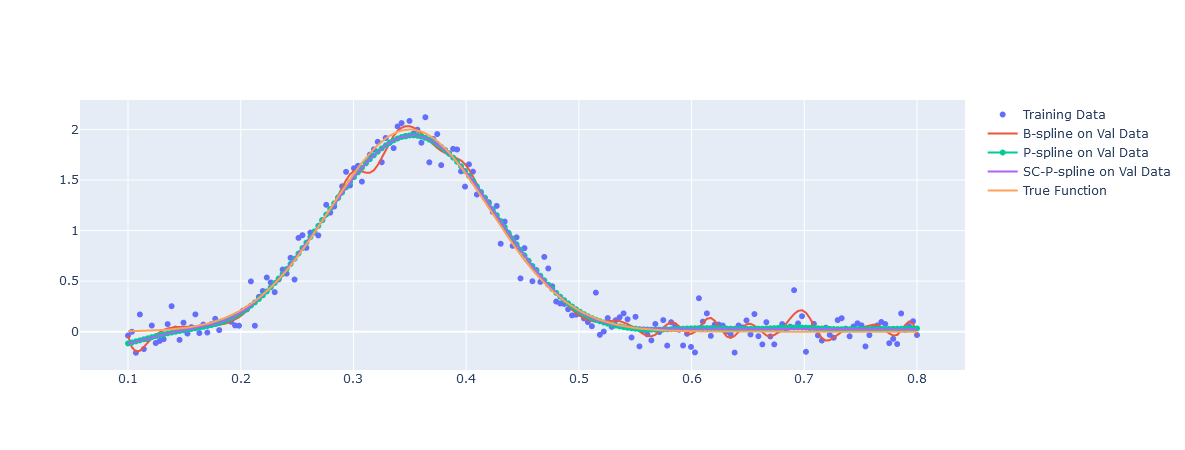

In [130]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y, mode="markers", name="Training Data"))
fig.add_trace(go.Scatter(x=xplot, y=Bspline_plot, mode="lines", name="B-spline on Val Data"))
fig.add_trace(go.Scatter(x=xplot, y=Pspline_plot, mode="lines+markers", name="P-spline on Val Data"))
fig.add_trace(go.Scatter(x=xplot, y=SCPspline_plot, mode="lines", name="SC-P-spline on Val Data"))
fig.add_trace(go.Scatter(x=x, y=ytrue, mode="lines", name="True Function"))

In [127]:
df_mse = pd.DataFrame(columns=["Model", "MSEVal", "MSEValTrueFunction"])
df_mse["Model"] = ["B-spline", "P-spline", "SCP-spline"]
df_mse["MSEValTrueFunction"] = [
    mean_squared_error(df_test["ytrue"].values, Bspline_pred).round(6),
    mean_squared_error(df_test["ytrue"].values, Pspline_pred).round(6),
    mean_squared_error(df_test["ytrue"].values, SCPspline_pred).round(6)]
df_mse["MSEVal"] = [
    mean_squared_error(df_test["y"].values, Bspline_pred).round(6),
    mean_squared_error(df_test["y"].values, Pspline_pred).round(6),
    mean_squared_error(df_test["y"].values, SCPspline_pred).round(6)
]

df_info = pd.DataFrame(columns=["Info", "Value"])
df_info["Info"] = ["Nr_splines", "Knot_type", "Spline_Order", "Opt_Lambda", "Lambda_c"]
df_info["Value"] = [nr_splines, knot_type, spline_order, opt_lam, lam_c]

df_plot = pd.DataFrame(data=dict(xplot=xplot, yplot=y, 
                                Bspline_fit=Bspline_plot,
                                Pspline_fit=Pspline_plot,
                                SCP_spline_fit=SCPspline_plot))
# df_info.to_csv(savePath+"info.txt", sep=" ", index=False)
# df_mse.to_csv(savePath+"mse.csv", sep=",", index=False)
# df_plot.to_csv(savePath+"data.txt", sep=" ", index=0)

## Peak example for different $\lambda_c$ for Chapter 4

Generate sparse data


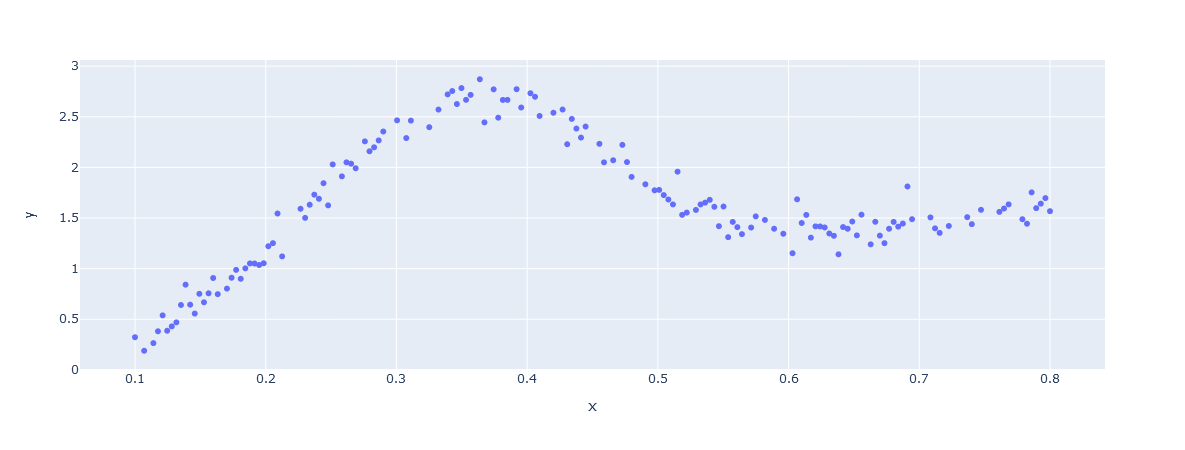

In [24]:
print("Generate sparse data")
np.random.seed(2)
n_data = 200
#x = np.random.random(n_data)*10
x = np.linspace(0.1,0.8, n_data)
ytrue = 2*np.exp(-(x-0.35)**2/0.025) 
noise = np.random.normal(loc=0, scale=0.1, size=x.shape)
y = ytrue + noise + 2*x

# train-test split
df = pd.DataFrame(data=dict(x=x, y=y, ytrue=ytrue))
df_train, df_test = train_test_split(df)

px.scatter(df_train, x="x", y="y")

In [200]:
print("Fit the different spline types")
nr_splines, knot_type, spline_order, lam_c = 45, "e", 3, 2000
B = Bspline()
sol = B.fit(df_train["x"].values, df_train["y"].values, nr_splines=nr_splines, knot_type="q")
opt_lam = B.calc_GCV(df_train["x"].values, df_train["y"].values,nr_splines=nr_splines, knot_type="q", nr_lam=100, plot_=0)["best_lambda"]
print("Optimal lambda = ",opt_lam)
sol_p = B.fit_Pspline(df_train["x"].values, df_train["y"].values,nr_splines=nr_splines,lam=opt_lam, knot_type=knot_type)

print("Test lambda_c = 0")
sol_c0 = B.fit_SC_Pspline(df_train["x"].values, df_train["y"].values, "peak", nr_splines, lam_c=0, knot_type=knot_type)
print("Test lambda_c = 10")
sol_c10 = B.fit_SC_Pspline(df_train["x"].values, df_train["y"].values, "peak", nr_splines, lam_c=10, knot_type=knot_type)
print("Test lambda_c = 100")
sol_c100 = B.fit_SC_Pspline(df_train["x"].values, df_train["y"].values, "peak", nr_splines, lam_c=100, knot_type=knot_type)
print("Test lambda_c = 1000")
sol_c1000 = B.fit_SC_Pspline(df_train["x"].values, df_train["y"].values, "peak", nr_splines, lam_c=1000, knot_type=knot_type)
print("Test lambda_c = 10000")
sol_c10000 = B.fit_SC_Pspline(df_train["x"].values, df_train["y"].values, "peak", nr_splines, lam_c=10000, knot_type=knot_type)

Fit the different spline types
Optimal lambda =  0.12915496650148853
========Pre-Iteration=========
-------MSE = 0.0040083--------
======== Iteration 1 =========
-------MSE = 0.0049098--------
======== Iteration 2 =========
-------MSE = 0.0050064--------


In [201]:
print("Show the mean squared errors")
Bspline_pred = B.predict(df_test["x"].values, sol["coef_"], sol["knots"])
Pspline_pred = B.predict(df_test["x"].values, sol_p["coef_"], sol_p["knots"])
SCPspline_pred = B.predict(df_test["x"].values, sol_c["coef_"], sol_c["knots"])

r = 8
print("".center(50,"="))
print("".center(50,"="))
print("MSEs compared to True Function")
print("".center(50,"="))
print("Validation Set".center(30, " "))
print("MSE-Val B-spline = ".ljust(25), mean_squared_error(df_test["ytrue"].values, Bspline_pred).round(r))
print("MSE-Val P-spline = ".ljust(25), mean_squared_error(df_test["ytrue"].values, Pspline_pred).round(r))
print("MSE-Val SC-P-spline = ".ljust(25), mean_squared_error(df_test["ytrue"].values, SCPspline_pred).round(r))
print("".center(50,"="))
print("Train Set".center(30, " "))
print("MSE-Train B-spline = ".ljust(25), 
      mean_squared_error(df_train["ytrue"].values, B.predict(df_train["x"].values, sol["coef_"], sol["knots"])).round(r))
print("MSE-Train P-spline = ".ljust(25), 
      mean_squared_error(df_train["ytrue"].values, B.predict(df_train["x"].values, sol_p["coef_"], sol_p["knots"])).round(r))
print("MSE-Train SC-P-spline = ".ljust(25), 
      mean_squared_error(df_train["ytrue"].values, B.predict(df_train["x"].values, sol_c["coef_"], sol_c["knots"])).round(r))
print("".center(50,"="))
print("MSEs compared to Noisy Function")
print("".center(50,"="))
print("Validation Set".center(30, " "))
print("MSE-Val B-spline = ".ljust(25), mean_squared_error(df_test["y"].values, Bspline_pred).round(r))
print("MSE-Val P-spline = ".ljust(25), mean_squared_error(df_test["y"].values, Pspline_pred).round(r))
print("MSE-Val SC-P-spline = ".ljust(25), mean_squared_error(df_test["y"].values, SCPspline_pred).round(r))
print("".center(50,"="))
print("Train set".center(30, " "))
print("MSE-Train B-spline = ".ljust(25), 
      mean_squared_error(df_train["y"].values, B.predict(df_train["x"].values, sol["coef_"], sol["knots"])).round(r))
print("MSE-Train P-spline = ".ljust(25),
      mean_squared_error(df_train["y"].values, B.predict(df_train["x"].values, sol_p["coef_"], sol_p["knots"])).round(r))
print("MSE-Train SC-P-spline = ".ljust(25), 
      mean_squared_error(df_train["y"].values, B.predict(df_train["x"].values, sol_c["coef_"], sol_c["knots"])).round(r))
print("".center(50,"="))

Show the mean squared errors
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
MSEs compared to True Function
        Validation Set        
MSE-Val B-spline =        70836.47147193
MSE-Val P-spline =        0.00404236
MSE-Val SC-P-spline =     0.00290575
          Train Set           
---Prediction for 1-D Data----
MSE-Train B-spline =      0.00763275
---Prediction for 1-D Data----
MSE-Train P-spline =      0.00349345
---Prediction for 1-D Data----
MSE-Train SC-P-spline =   0.00290731
MSEs compared to Noisy Function
        Validation Set        
MSE-Val B-spline =        70841.58896042
MSE-Val P-spline =        0.01527898
MSE-Val SC-P-spline =     0.0151566
          Train set           
---Prediction for 1-D Data----
MSE-Train B-spline =      0.00173019
---Prediction for 1-D Data----
MSE-Train P-spline =      0.00400835
---Prediction for 1-D Data----
MSE-Train SC-P-spline =   0.00500638


---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----


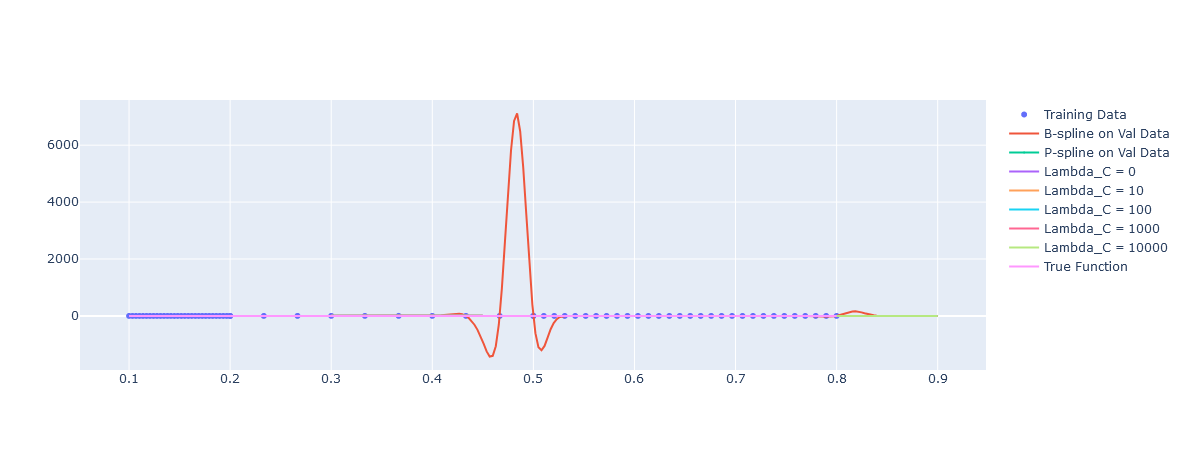

In [202]:
# add the predictions to the dataset and save it
xplot = np.linspace(0.3,0.9,200)
Bspline_plot = B.predict(xplot, sol["coef_"], sol["knots"])
Pspline_plot = B.predict(xplot, sol_p["coef_"], sol_p["knots"])
SCPspline_plot0 = B.predict(xplot, sol_c0["coef_"], sol_c0["knots"])
SCPspline_plot10 = B.predict(xplot, sol_c10["coef_"], sol_c10["knots"])
SCPspline_plot100 = B.predict(xplot, sol_c100["coef_"], sol_c100["knots"])
SCPspline_plot1000 = B.predict(xplot, sol_c1000["coef_"], sol_c1000["knots"])
SCPspline_plot10000 = B.predict(xplot, sol_c10000["coef_"], sol_c10000["knots"])

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode="markers", name="Training Data"))
fig.add_trace(go.Scatter(x=xplot, y=Bspline_plot, mode="lines", name="B-spline on Val Data"))
fig.add_trace(go.Scatter(x=xplot, y=Pspline_plot, mode="lines+markers", marker=dict(size=1), name="P-spline on Val Data"))
fig.add_trace(go.Scatter(x=xplot, y=SCPspline_plot0, mode="lines", name="Lambda_C = 0"))
fig.add_trace(go.Scatter(x=xplot, y=SCPspline_plot10, mode="lines", name="Lambda_C = 10"))
fig.add_trace(go.Scatter(x=xplot, y=SCPspline_plot100, mode="lines", name="Lambda_C = 100"))
fig.add_trace(go.Scatter(x=xplot, y=SCPspline_plot1000, mode="lines", name="Lambda_C = 1000"))
fig.add_trace(go.Scatter(x=xplot, y=SCPspline_plot10000, mode="lines", name="Lambda_C = 10000"))

fig.add_trace(go.Scatter(x=x, y=ytrue, mode="lines", name="True Function"))

## Peak Example for Sparse Data in Chapter 4

Generate sparse data


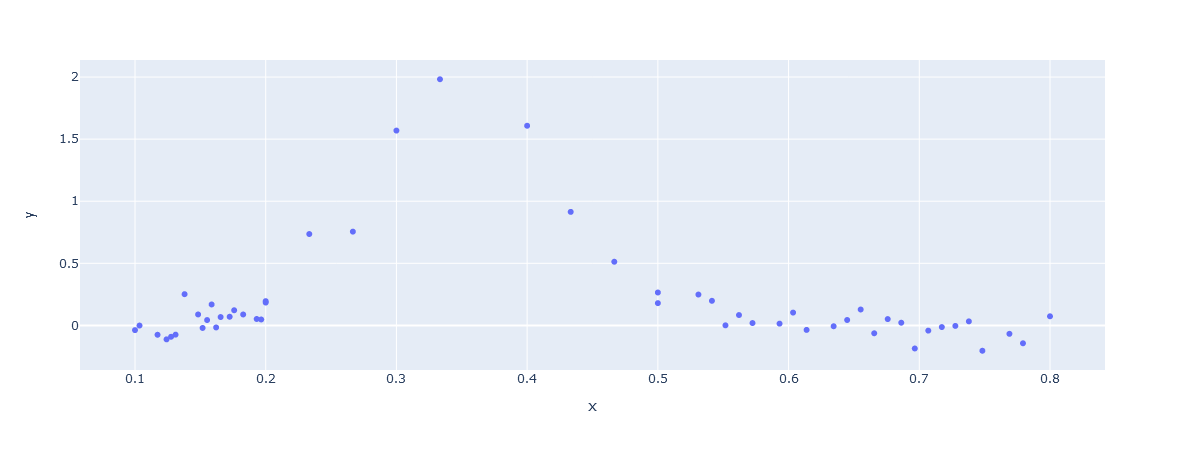

In [25]:
savePath = os.path.join(os.path.dirname("."), '../../Thesis/tex/graphics/data/cha4/sparse_example/')
print("Generate sparse data")
np.random.seed(2)
n_data = 200
x1 = np.linspace(0.1,0.2, 30)
x2 = np.linspace(0.2,0.5, 10)
x3 = np.linspace(0.5,0.8, 30)
x = np.hstack((x1,x2,x3))

ytrue = 2*np.exp(-(x-0.35)**2/0.01) 
noise = np.random.normal(loc=0, scale=0.1, size=x.shape)
y = ytrue + noise

# train-test split
df = pd.DataFrame(data=dict(x=x, y=y, ytrue=ytrue))
df_train, df_test = train_test_split(df)

px.scatter(df_train, x="x", y="y")

In [32]:
print("Fit the different spline types")
nr_splines, knot_type, spline_order, lam_c = 30, "q", 3, 1000
B = Bspline()
sol = B.fit(df_train["x"].values, df_train["y"].values, nr_splines=nr_splines, knot_type=knot_type)
opt_lam = B.calc_GCV(df_train["x"].values, df_train["y"].values,nr_splines=nr_splines, nr_lam=100, plot_=0, knot_type=knot_type)["best_lambda"]
print("Optimal lambda = ",opt_lam)
sol_p = B.fit_Pspline(df_train["x"].values, df_train["y"].values,nr_splines=nr_splines,lam=opt_lam, knot_type=knot_type)
sol_c = B.fit_SC_Pspline(df_train["x"].values, df_train["y"].values, "peak", nr_splines, lam_c=lam_c, knot_type=knot_type)

Fit the different spline types
Optimal lambda =  0.006579332246575682
========Pre-Iteration=========
-------MSE = 0.0046824--------
======== Iteration 1 =========
-------MSE = 0.0066226--------
======== Iteration 2 =========
--------MSE = 0.007056--------
======== Iteration 3 =========
-------MSE = 0.0070819--------


In [33]:
print("Show the mean squared errors")
Bspline_pred = B.predict(df_test["x"].values, sol["coef_"], sol["knots"])
Pspline_pred = B.predict(df_test["x"].values, sol_p["coef_"], sol_p["knots"])
SCPspline_pred = B.predict(df_test["x"].values, sol_c["coef_"], sol_c["knots"])

Show the mean squared errors
---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----


In [34]:
print("".center(50,"="))
print("".center(50,"="))
print("MSEs compared to True Function")
print("".center(50,"="))
print("Validation Set".center(30, " "))
print("MSE-Val B-spline = ".ljust(25), mean_squared_error(df_test["ytrue"].values, Bspline_pred).round(6))
print("MSE-Val P-spline = ".ljust(25), mean_squared_error(df_test["ytrue"].values, Pspline_pred).round(6))
print("MSE-Val SC-P-spline = ".ljust(25), mean_squared_error(df_test["ytrue"].values, SCPspline_pred).round(6))
print("".center(50,"="))
print("Train Set".center(30, " "))
print("MSE-Train B-spline = ".ljust(25), mean_squared_error(df_train["ytrue"].values, B.predict(df_train["x"].values, sol["coef_"], sol["knots"])).round(6))
print("MSE-Train P-spline = ".ljust(25), mean_squared_error(df_train["ytrue"].values, B.predict(df_train["x"].values, sol_p["coef_"], sol_p["knots"])).round(6))
print("MSE-Train SC-P-spline = ".ljust(25), mean_squared_error(df_train["ytrue"].values, B.predict(df_train["x"].values, sol_c["coef_"], sol_c["knots"])).round(6))
print("".center(50,"="))
print("MSEs compared to Noisy Function")
print("".center(50,"="))
print("Validation Set".center(30, " "))
print("MSE-Val B-spline = ".ljust(25), mean_squared_error(df_test["y"].values, Bspline_pred).round(6))
print("MSE-Val P-spline = ".ljust(25), mean_squared_error(df_test["y"].values, Pspline_pred).round(6))
print("MSE-Val SC-P-spline = ".ljust(25), mean_squared_error(df_test["y"].values, SCPspline_pred).round(6))
print("".center(50,"="))
print("Train set".center(30, " "))
print("MSE-Train B-spline = ".ljust(25), mean_squared_error(df_train["y"].values, B.predict(df_train["x"].values, sol["coef_"], sol["knots"])).round(6))
print("MSE-Train P-spline = ".ljust(25), mean_squared_error(df_train["y"].values, B.predict(df_train["x"].values, sol_p["coef_"], sol_p["knots"])).round(6))
print("MSE-Train SC-P-spline = ".ljust(25), mean_squared_error(df_train["y"].values, B.predict(df_train["x"].values, sol_c["coef_"], sol_c["knots"])).round(6))
print("".center(50,"="))

MSEs compared to True Function
        Validation Set        
MSE-Val B-spline =        0.009236
MSE-Val P-spline =        0.00645
MSE-Val SC-P-spline =     0.00356
          Train Set           
---Prediction for 1-D Data----
MSE-Train B-spline =      0.005914
---Prediction for 1-D Data----
MSE-Train P-spline =      0.004081
---Prediction for 1-D Data----
MSE-Train SC-P-spline =   0.002065
MSEs compared to Noisy Function
        Validation Set        
MSE-Val B-spline =        0.025241
MSE-Val P-spline =        0.020679
MSE-Val SC-P-spline =     0.015905
          Train set           
---Prediction for 1-D Data----
MSE-Train B-spline =      0.003826
---Prediction for 1-D Data----
MSE-Train P-spline =      0.004682
---Prediction for 1-D Data----
MSE-Train SC-P-spline =   0.007082


In [35]:
# add the predictions to the dataset and save it
xplot = np.linspace(0.1,0.8,1000)
yplot = 2*np.exp(-(xplot-0.35)**2/0.01) 
Bspline_plot = B.predict(xplot, sol["coef_"], sol["knots"])
Pspline_plot = B.predict(xplot, sol_p["coef_"], sol_p["knots"])
SCPspline_plot = B.predict(xplot, sol_c["coef_"], sol_c["knots"])

---Prediction for 1-D Data----
---Prediction for 1-D Data----
---Prediction for 1-D Data----


Knot type:  q


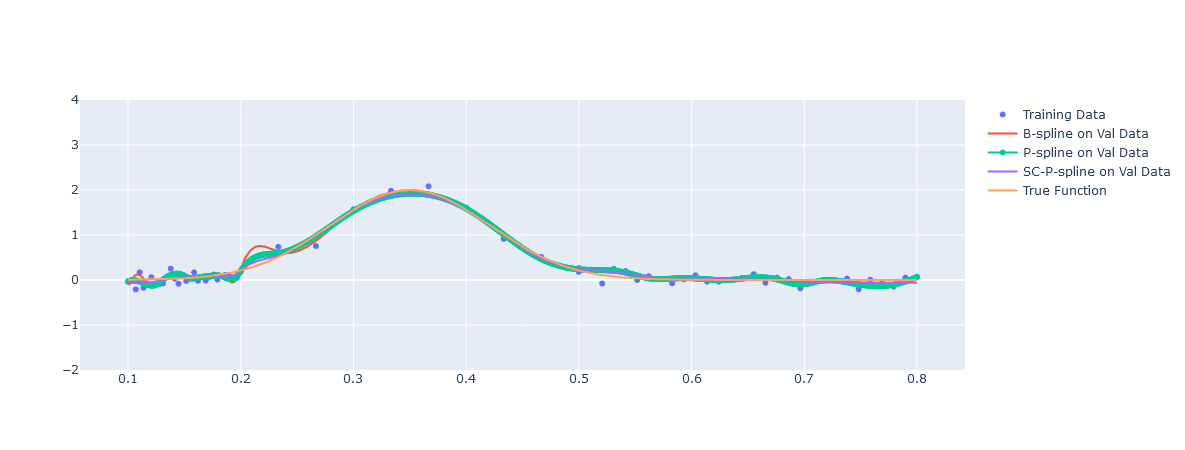

In [36]:
fig = go.Figure()
print("Knot type: ", knot_type)
fig.add_trace(go.Scatter(x=x, y=y, mode="markers", name="Training Data"))
fig.add_trace(go.Scatter(x=xplot, y=Bspline_plot, mode="lines", name="B-spline on Val Data"))
fig.add_trace(go.Scatter(x=xplot, y=Pspline_plot, mode="lines+markers", name="P-spline on Val Data"))
fig.add_trace(go.Scatter(x=xplot, y=SCPspline_plot, mode="lines", name="SC-P-spline on Val Data"))
fig.add_trace(go.Scatter(x=xplot, y=yplot, mode="lines", name="True Function"))
fig.update_yaxes(range=[-2, 4])

In [17]:
df_mse = pd.DataFrame(columns=["Model", "MSEVal", "MSEValTrueFunction"])
df_mse["Model"] = ["B-spline", "P-spline", "SCP-spline"]
df_mse["MSEValTrueFunction"] = [
    mean_squared_error(df_test["ytrue"].values, Bspline_pred).round(6),
    mean_squared_error(df_test["ytrue"].values, Pspline_pred).round(6),
    mean_squared_error(df_test["ytrue"].values, SCPspline_pred).round(6)]
df_mse["MSEVal"] = [
    mean_squared_error(df_test["y"].values, Bspline_pred).round(6),
    mean_squared_error(df_test["y"].values, Pspline_pred).round(6),
    mean_squared_error(df_test["y"].values, SCPspline_pred).round(6)
]

df_info = pd.DataFrame(columns=["Info", "Value"])
df_info["Info"] = ["Nr_splines", "Knot_type", "Spline_Order", "Opt_Lambda", "Lambda_c"]
df_info["Value"] = [nr_splines, knot_type, spline_order, opt_lam, lam_c]
df_plot_fit = pd.DataFrame(data=dict(xplot=xplot, yplot=yplot,
                                     Bspline_fit=Bspline_plot,
                                     Pspline_fit=Pspline_plot,
                                     SCP_spline_fit=SCPspline_plot))
df_plot_data = pd.DataFrame(data=dict(x=x, y=y))

In [18]:
df_mse.to_csv(savePath+f"mse-{knot_type}.csv", sep=",", index=False)
df_info.to_csv(savePath+f"info-{knot_type}.txt", sep=" ", index=False)
df_plot_data.to_csv(savePath+f"data-{knot_type}.txt", sep=" ", index=False)
df_plot_fit.to_csv(savePath+f"fit-{knot_type}.txt", sep=" ", index=False)

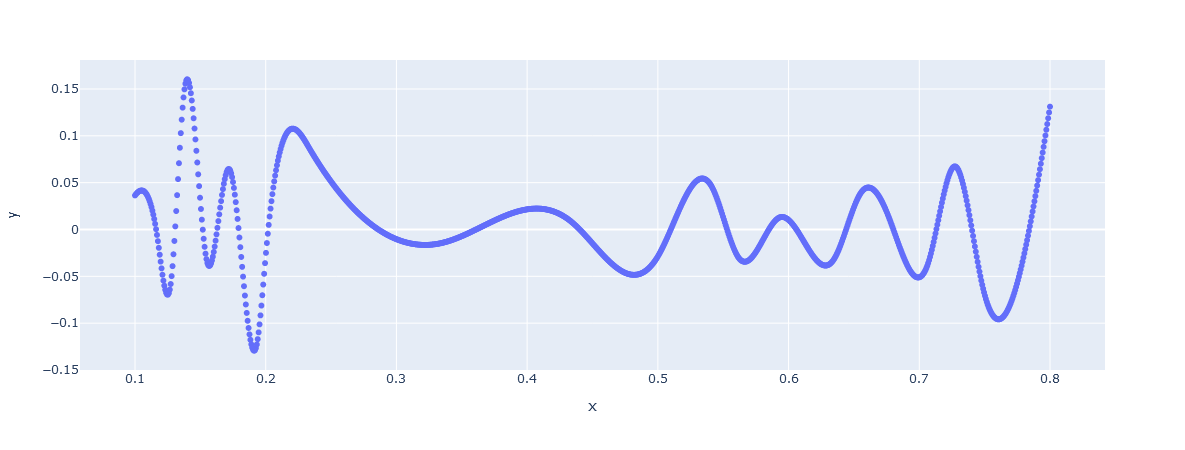

In [11]:
px.scatter(x=xplot, y=Pspline_plot- SCPspline_plot)

In [25]:
def star_model(descr, X, y):
        
    BS, TS = Bspline(), Bspline()
    basis, smoothness = [], []
    constraints, optimal_lambdas = [], []
    weights, coef_ = [], []
    S, K = [], []

    for e in descr:
        if e[0].startswith("s"):
            B = BS.basismatrix(X=X[:,int(e[0][2])-1], nr_splines=e[1], l=3, knot_type=e[-1])["basis"]
            D = mapping_matrix(n_param=e[1], constraint="smooth")
            C = mapping_matrix(n_param=e[1], constraint=e[2])
            lam = BS.calc_GCV(X=X[:,int(e[0][2])-1], y=y, nr_splines=e[1], l=3, knot_type=e[-1], nr_lam=50, plot_=0)["best_lambda"]
            coef_pls = BS.fit_Pspline(X=X[:,int(e[0][2])-1], y=y, nr_splines=e[1], l=3, knot_type=e[-1], lam=lam)["coef_"]
            weights.append(check_constraint(coef=coef_pls, constraint=e[2], y=y, B=B))
        elif e[0].startswith("t"):
            B = TS.tensorproduct_basismatrix(X=X[:,[int(e[0][2])-1, int(e[0][4])-1]], nr_splines=e[1], l=(3,3), knot_type=e[-1])["basis"]
            D = mapping_matrix_tp(n_param=e[1], constraints=("smooth", "smooth"))
            C = mapping_matrix_tp(n_param=e[1], constraints=e[2])
            lam = TS.calc_GCV(X=X[:,[int(e[0][2])-1, int(e[0][4])-1]], y=y, nr_splines=e[1], l=(3,3), knot_type=e[-1], nr_lam=50, plot_=0)["best_lambda"]
            coef_pls = TS.fit_Pspline(X=X[:,[int(e[0][2])-1, int(e[0][4])-1]], y=y, nr_splines=e[1], l=(3,3), knot_type=e[-1], lam=(lam, lam))["coef_"]
            weights1 = check_constraint_tp(coef_pls, nr_param=e[1], constraint=e[2][0], direction=1)
            weights2 = check_constraint_tp(coef_pls, nr_param=e[1], constraint=e[2][1], direction=0)
            weights.append((weights1,weights2))
        else:
            print("Only B-splines (s) and tensor-product B-splines (t) are supported!")
            return
        basis.append(B)
        smoothness.append(D)
        constraints.append(C)
        optimal_lambdas.append(lam)
        coef_.append(coef_pls)
        
    # create combined basis matrix
    B = np.concatenate(basis, axis=1)
    # create combined smoothness matrix
    for i, s in enumerate(smoothness):
        if len(s) == 2:
            S.append(optimal_lambdas[i]*(s[0].T @ s[0]) + optimal_lambdas[i]*(s[1].T@s[1]))
        else:
            S.append(optimal_lambdas[i]* (s.T@s))
    S = block_diag(*S)
    # create combined constraint matrix
    for i, c in enumerate(constraints):
        if len(c) == 2:
            K.append(6000*(c[0].T @ np.diag(weights[i][0]) @ c[0]) + 6000*(c[1].T @np.diag(weights[i][1]) @ c[1]))
        else:
            K.append(6000* (c.T@ np.diag(weights[i])@c))
    K = block_diag(*K)
    
    weights_old = [0]*len(weights)
    iterIdx = 1
    BtB = B.T @ B
    Bty = B.T @ y
    
    # Iterate till no change in weights
    while not (weights == weights_old):
        weights_old = weights
        coef_ = np.linalg.pinv(BtB + S + K) @ (Bty)
        weights = check_constraint_full(coef_=coef_, descr=m, basis=B, y=y)

        print(f" Iteration {iterIdx} ".center(50, "="))
        print(f"MSE = {mean_squared_error(y, B@coef_).round(7)}".center(50, "-"))
        
        K = []
        print("Calculate new constraint matrix K".center(50,"-"))
        for i, c in enumerate(constraints):
            if len(c) == 2:
                K.append(descr[i][3]*(c[0].T @ np.diag(weights[i][0]) @ c[0]) + descr[i][3]*(c[1].T @np.diag(weights[i][1]) @ c[1]))
            else:
                K.append(descr[i][3]*(c.T@ np.diag(weights[i])@c))
        K = block_diag(*K)

        if iterIdx > 200:
            print("breaking")
            break

        iterIdx += 1
        
        
    return dict(basis=B, smoothness=S, constraint=K, opt_lambdas=optimal_lambdas, coef_=coef_, weights=weights)


In [27]:
m = ( ("t(1,2)", (5,5), ("conc", "none"), 6000, ("e", "q")), 
      ("s(1)", 10, "peak", 2000, "e"), 
      ("s(2)", 15, "inc", 10, "q"), 
 )
XX = np.array([np.random.uniform(0,1,500), np.random.uniform(1,11, 500)]).T
#XX = np.array([np.linspace(0,1,25), np.linspace(1,11,25)]).T
y = XX[:,0]**2 * XX[:,1] + np.sin(XX[:,1]) + np.random.normal(size=XX[:,0].shape)*0.5

#sol = star_model(m, XX, y)

In [282]:
@singledispatch
def cc(nr_param, coef, constraint, y=None, B=None):
    """Check whether the coefficients in coef hold true to the constraint for
    the B-spline coefficients.

    Parameters:
    -----------
    nr_param : int    - Number of B-spline basis function coefficients.
    coef  : array     - Array of coefficients to test against the constraint.
    constraint : str  - Constraint type.
    y  : array        - Output data.
    B  : matrix       - B-spline basis matrix.

    Returns:
    --------
    v  : array      - Diagonal elements of the weighting matrix V.
    """
    
    avail_constraints = ["inc", "dec","conv","conc","none","peak", "valley"]
    assert (constraint in avail_constraints), "Argument 'constraint' not available."

    threshold = 0 #1e-4;
    
    if constraint == "inc":
        v = np.diff(coef) < threshold
    elif constraint == "dec":
        v = np.diff(coef) > -threshold
    elif constraint == "conv":
        v = np.diff(coef, 2) < threshold
    elif constraint == "conc":
        v = np.diff(coef, 2) > -threshold
    elif constraint == "peak":
        assert (np.all(y != None) and np.all(B != None)), "Include the output y and B-spline basis matrix B."
        peakidx = np.argmax(y)
        peak_spline_idx = np.argmax(B[peakidx,:])
        v = list(np.diff(coef[:peak_spline_idx]) < threshold) + list(np.diff(coef[peak_spline_idx-1:]) > -threshold)
    elif constraint == "valley":
        assert (np.all(y != None) and np.all(B != None)), "Include the output y."
        valleyidx = np.argmin(y)
        valley_spline_idx = np.argmin(B[valleyidx,:])
        v = list(np.diff(coef[:valley_spline_idx]) > -threshold) + [False] + list(np.diff(coef[valley_spline_idx:]) < threshold)
    else:
        v = np.zeros(len(coef)-2)
    return list(v.astype(int))

@cc.register
def _(nr_param : tuple, coef, constraint, dim=0):
    """Check whether the coefficients in coef hold true to the constraint for 
    the tensor-product B-spline coefficients.

    Parameters:
    -----------
    nr_param : tuple  - Number of B-spline basis functions for both dimensions
                        of the tensor-product B-spline.
    coef  : array     - Array of coefficients to test against the constraint.
    constraint : str  - Constraint type.
    dim : int         - Either 0 or 1 indication the dimension of the constraint. 
                        0 is row-wise and 1 is column-wise. 

    Returns:
    --------
    v  : array      - Diagonal elements of the weighting matrix V. 
    """
    print("TP constraint")
    avail_constraints = ["inc", "dec", "conv","conc", "none"]
    assert (constraint in avail_constraints), "Argument 'constraint' not available."
    threshold = 0
    
    if constraint == "inc":
        v = np.diff(coef.reshape(nr_param[0], nr_param[1]), axis=dim) < threshold
    elif constraint == "dec":
        v = np.diff(coef.reshape(nr_param[0], nr_param[1]), axis=dim) > -threshold
    elif constraint == "conv":
        v = np.diff(coef.reshape(nr_param[0], nr_param[1]), 2,  axis=dim) < threshold
    elif constraint == "conc":
        v = np.diff(coef.reshape(nr_param[0], nr_param[1]), 2,  axis=dim) > -threshold
    else:
        order = nr_param[0] if dim == 1 else nr_param[1]
        v = np.zeros(nr_param[0]*nr_param[1]-2*order)
    return list(v.ravel().astype(int))

@cc.register
def _(nr_param : dict, coef, basis=0, y=0):
    """Checks the respective parts of the coef vector against 
    the respective constraint constraints. 
    
    Paramters:
    ----------
    nr_param : dict  - Model description dictionary, e.g.
                        >>>m = ( ("t(1,2)", (5,5), ("conc", "none"), 6000, ("e", "q")), 
                           ("s(1)", 10, "inc", 2000, "e"), 
                           ("s(2)", 15, "inc", 10, "q"), 
                           )
                        >>>nr_param = dict()
                        >>>for i in m:
                               nr_param[i[0]] = dict(nr_param=i[1], constraint=i[2], lam=i[3], knot_type=i[4])
   
    coef : array    - Vector of coefficients.
    
    Returns:
    --------
    v : list    - Diagonal elements of the weighting matrix V.
    
    """
    print("INside check_full")
    i, v = 0, []
    for k,val in nr_param.items():
        if k[0].startswith("s"):
            c = coef[i:val["nr_param"]+i]
            v.append(cc(val["nr_param"], coef=c, constraint=val["constraint"], y=y, B=basis[:, i:val["nr_param"]+i]))
        elif k[0].startswith("t"):
            c = coef[i:np.prod(val["nr_param"])+i]
            v1 = cc(val["nr_param"], c, constraint=val["constraint"][0], dim=int(k[2])-1)
            v2 = cc(val["nr_param"], c, constraint=val["constraint"][1], dim=int(k[2])-1)
            v.append((v1,v2))
        else:
            print("Only B-splines (s) and tensor-product B-splines (t) are supported!")
            return
        i += np.prod(val["nr_param"])
    return v
